# Mounting Google Drive

In [1]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


# Importing libraries

In [2]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import backend as tfkn
import matplotlib.pyplot as plt
%matplotlib inline
import random
from sklearn.model_selection import train_test_split

seed = 54
np.random.seed(seed)
tf.random.set_seed(seed)

# training parameters
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
PATIENCE = 20
EPOCHS = 100

# Loading and assembling data

In [3]:
data = np.load("mars_for_students.npz")
data_no_aliens = np.load("No_aliens_light.npz")

#loading the labels generated by the Multi-output model
predictions_test = np.load("predictions_test.npz")
predictions_train_val = np.load("predictions_train_val.npz")


X_train_val = data_no_aliens['arr_0']
y_train_val = data_no_aliens['arr_1']

X_train_val_preds = predictions_train_val['arr_0']
X_train_val_preds2 = predictions_train_val['arr_1']

X_test_preds = predictions_test['arr_0']
X_test_preds2 = predictions_test['arr_1']

X_test = data["test_set"]


# splitting the annotated data in the same way that was used for training the Multi-output model
X_train_val, X_v0, y_training, y_val = train_test_split(X_train_val, y_train_val, random_state = seed, test_size = 0.1)
X_train_val_preds, X_v1 = train_test_split(X_train_val_preds, random_state = seed, test_size = 0.1)
X_train_val_preds2, X_v2 = train_test_split(X_train_val_preds2, random_state = seed, test_size = 0.1)


# preparing the data for the concatenation
X_train_val = tf.reshape(X_train_val, [2254, 64, 128, 1])
X_train_val_preds = tf.reshape(X_train_val_preds, [2254, 64, 128, 1])
X_train_val_preds2 = tf.reshape(X_train_val_preds2, [2254, 64, 128, 1])

X_train_val_preds = tf.cast(X_train_val_preds, tf.uint8)
X_train_val_preds2 = tf.cast(X_train_val_preds2, tf.uint8)


X_v0 = tf.reshape(X_v0, [251, 64, 128, 1])
X_v1 = tf.reshape(X_v1, [251, 64, 128, 1])
X_v2 = tf.reshape(X_v2, [251, 64, 128, 1])

X_v1 = tf.cast(X_v1, tf.uint8)
X_v2 = tf.cast(X_v2, tf.uint8)


X_test = tf.reshape(X_test, [10022, 64, 128, 1])
X_test_preds = tf.reshape(X_test_preds, [10022, 64, 128, 1])
X_test_preds2 = tf.reshape(X_test_preds2, [10022, 64, 128, 1])

X_test_preds = tf.cast(X_test_preds, tf.uint8)
X_test_preds2 = tf.cast(X_test_preds2, tf.uint8)


# assembling data
X_test = tf.concat([X_test,X_test_preds,X_test_preds2],axis = -1)
X_training = tf.concat([X_train_val,X_train_val_preds,X_train_val_preds2],axis = -1)
X_val = tf.concat([X_v0,X_v1,X_v2],axis = -1)



print(X_training.shape, y_training.shape, X_test.shape)

(2254, 64, 128, 3) (2254, 64, 128) (10022, 64, 128, 3)


# Consistency check
Plotting:

*   image from the training set
*   first label generated by the Multi-output model
*   second label generated by the Multi-output model
*   true label



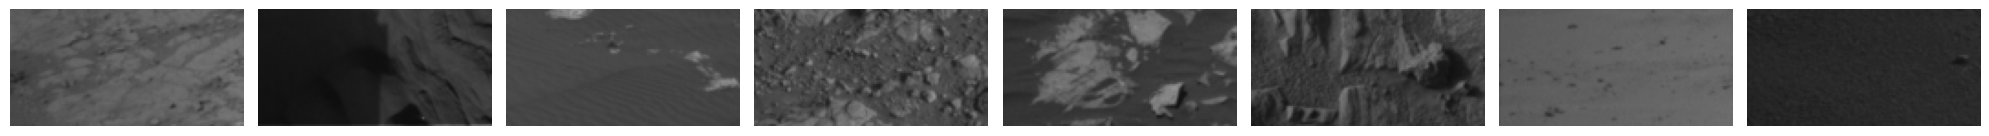

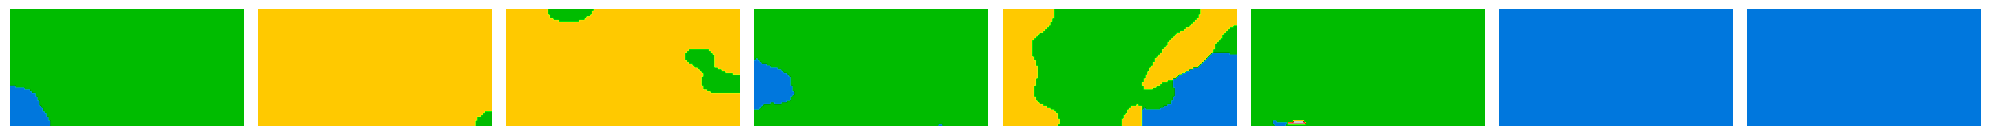

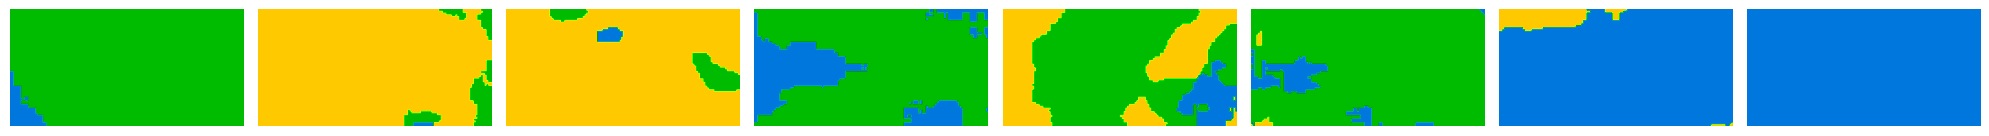

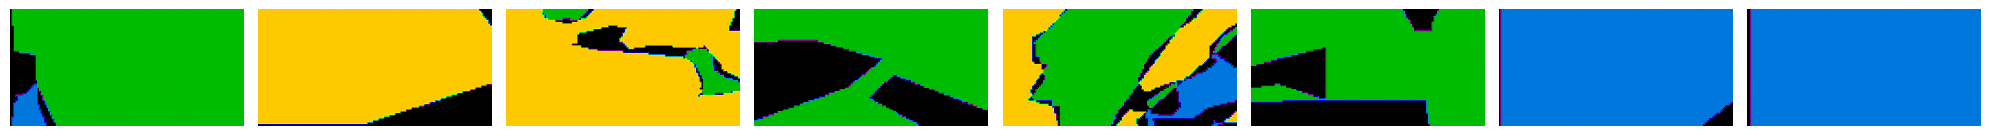

[979, 1454, 1878, 67, 881, 758, 1266, 325]


In [4]:
num_img = 8
random_indices = random.sample(range(len(X_training)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_training[idx,:,:,0]), vmin=0, vmax=255,cmap='gray')
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

fig2, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_training[idx,:,:,1]), cmap = 'nipy_spectral',vmin=0, vmax=4)
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

fig3, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_training[idx,:,:,2]), cmap = 'nipy_spectral',vmin=0, vmax=4)
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

fig4, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(y_training[idx]), cmap = 'nipy_spectral',vmin=0, vmax=4)
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

print(random_indices)

# Postprocessing model
Parallel of two different models, taking as input the concatenation of the image with the two labels from the Multi-output model

In [5]:
filtri = 32

In [6]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [7]:
def RSN_block(input_tensor, filters, name='', skip=0):
    x0 = input_tensor

    x = tfkl.Conv2D(filters, kernel_size = 1, padding = 'same', name = name + '_conv_1X1')(x0)
    x = tfkl.BatchNormalization(name = name + '_bn_1')(x)
    x = tfkl.LeakyReLU(0.15)(x)

    x = tfkl.Conv2D(filters, kernel_size = 3, padding = 'same', name = name + '_conv_3X3')(x)
    x = tfkl.BatchNormalization(name = name + '_bn_2')(x)
    x = tfkl.LeakyReLU(0.15)(x)

    x = tfkl.Conv2D(filters*2, kernel_size = 1, padding = 'same', name = name + '_conv_1X1_bis')(x)
    x = tfkl.BatchNormalization(name = name + '_bn_3')(x)
    x = tfkl.LeakyReLU(0.15)(x)

    if skip == 1:
      x_skip = tfkl.Conv2D(filters*2, kernel_size = 1, padding = 'same', name = name + '_conv_1X1_skip')(x0)
      x_skip = tfkl.LeakyReLU(0.15)(x_skip)
      x0 = tfkl.Add()([x, x_skip])
    else:
      x0 = tfkl.Concatenate()([x,x0])

    return x0

def DECODER_block(input_tensor, filters, name = ''):
    x = input_tensor
    x = tfkl.Conv2D(filters, kernel_size = 3, padding = 'same', name = name + '_conv')(x)
    x = tfkl.BatchNormalization(name = name + '_bn')(x)
    x = tfkl.Conv2DTranspose(filters, kernel_size = 3, padding = 'same', name = name + '_conv_transp')(x)
    x = tfkl.LeakyReLU(0.15)(x)

    return x

def get_model(input_shape = (64, 128, 3), num_classes = 5, seed = seed):
    tf.random.set_seed(seed)
    il = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path 0

    down_block_1 = unet_block(il, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck 0
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path 0
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Downsampling path 1
    x = tfkl.Conv2D(64, kernel_size = 5, padding = 'same', name = 'initial_conv')(il)
    x = tfkl.BatchNormalization(name = 'initial_bn')(x)
    x = tfkl.LeakyReLU(0.15)(x)

    RSB_1 = RSN_block(x, filtri, name = 'RSB_1', skip = 0)
    RSB_2 = RSN_block(RSB_1, filtri, name = 'RSB_2', skip = 1)
    RSB_3 = RSN_block(RSB_2, filtri, name = 'RSB_3', skip = 1)

    RSB_4 = RSN_block(RSB_3, 2*filtri, name = 'RSB_4', skip = 0)
    RSB_5 = RSN_block(RSB_4, 2*filtri, name = 'RSB_5', skip = 1)
    RSB_6 = RSN_block(RSB_5, 2*filtri, name = 'RSB_6', skip = 1)
    RSB_7 = RSN_block(RSB_6, 2*filtri, name = 'RSB_7', skip = 1)

    # Upsampling path 1

    DEC_1 = DECODER_block(RSB_7, 4*filtri, name = 'dec_1')
    skip_2 = tfkl.Concatenate()([DEC_1, RSB_3])
    DEC_2a = DECODER_block(skip_2, 4*filtri, name = 'dec_2a')
    DEC_2b = DECODER_block(DEC_2a, 2*filtri, name = 'dec_2b')
    skip_1 = tfkl.Concatenate()([DEC_2b, x])

    x = tfkl.Conv2D(2*filtri, kernel_size = 3, padding = 'same', name = 'dec_3_conv1')(skip_1)
    x = tfkl.BatchNormalization(name = 'dec_3_bn1')(x)
    x = tfkl.Conv2D(filtri, kernel_size = 3, padding = 'same', name = 'dec_3_conv2')(x)
    x = tfkl.BatchNormalization(name = 'dec_3_bn2')(x)

    x = tfkl.Concatenate()([x,u2])

    output = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output')(x)
    model = tf.keras.Model(inputs = il, outputs = output, name='o2')

    return model

In [11]:
model = get_model()
mean_iou1 = tfk.metrics.MeanIoU(num_classes = 5, ignore_class = 0, sparse_y_pred = False, name = 'mIoU')

model.compile(
    loss = tfk.losses.SparseCategoricalCrossentropy(ignore_class = 0),
    optimizer = tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics = [mean_iou1]
)
early_stopping = tfk.callbacks.EarlyStopping(monitor = 'val_mIoU', mode = 'max', patience = PATIENCE, restore_best_weights = True)

# Training

In [12]:
history = model.fit(
    X_training,
    y_training,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data=[X_val, y_val],
    callbacks = [early_stopping],
    verbose = 1
).history
final_val_meanIoU = round(max(history['val_mIoU'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)
del model
print(f"Model saved to {model_filename}")

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - loss: 0.6625 - mIoU: 0.3885 - val_loss: 6.1595 - val_mIoU: 0.2096
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 0.1069 - mIoU: 0.7407 - val_loss: 3.1796 - val_mIoU: 0.3063
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.1116 - mIoU: 0.7580 - val_loss: 6.6776 - val_mIoU: 0.1194
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.0644 - mIoU: 0.8450 - val_loss: 7.5594 - val_mIoU: 0.2037
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.0353 - mIoU: 0.8606 - val_loss: 2.4775 - val_mIoU: 0.3083
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0464 - mIoU: 0.8544 - val_loss: 4.9376 - val_mIoU: 0.0476
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0459 - mIoU: 0.8999 - val_loss: 0.4898 - val_mIoU: 0.6533
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0412 - mIoU: 0.8139 - val_loss: 1.2315 - val_mIoU: 0.3939
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/s

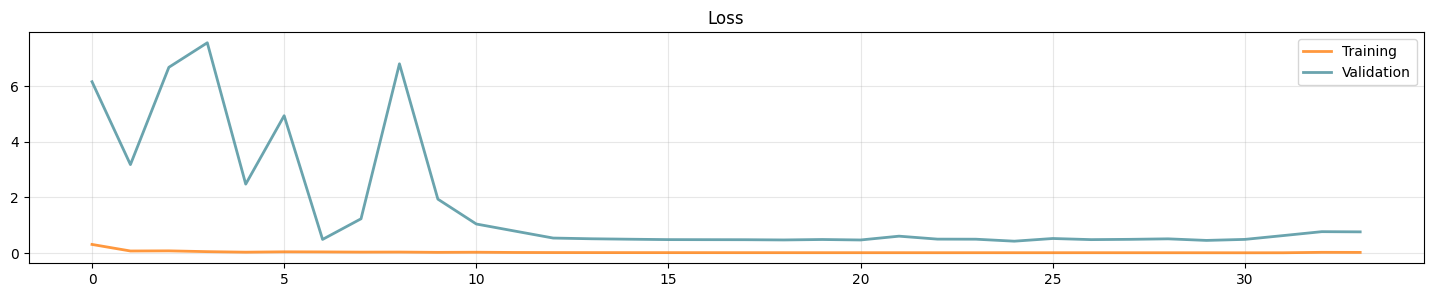

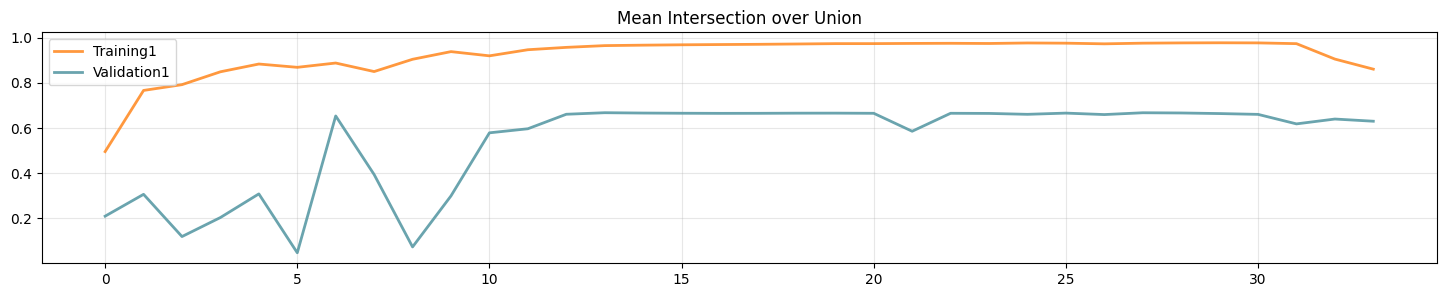

In [13]:
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(18, 3))
plt.plot(history['mIoU'], label='Training1', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mIoU'], label='Validation1', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Preparing the submission
Notice that the test set had to be integrated with the predictions of the Multiple-outputs model

In [14]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [15]:
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from UNet_66.77.keras


In [16]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 75s 196ms/step
Predictions shape: (10022, 64, 128)


In [17]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [18]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# visualizing the refined predictions
Plotting:

*   best label generated by the Multi-output model
*   label generated by the postprocessing model
*   superimposition of the image and its predicted label



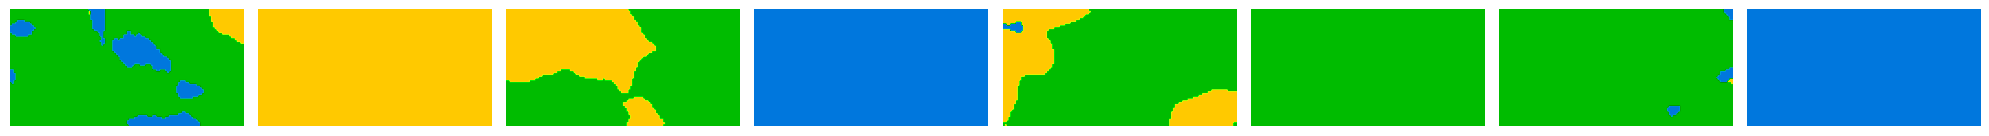

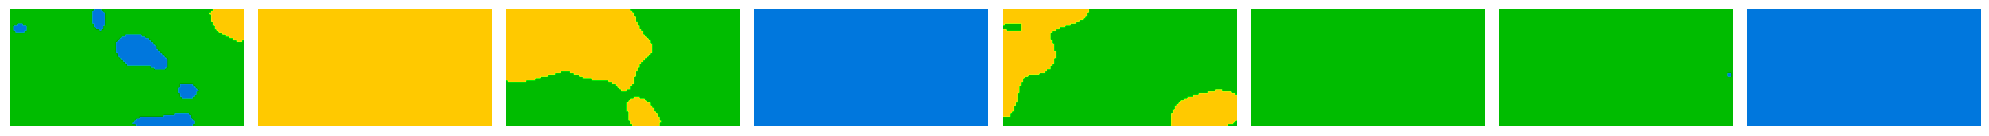

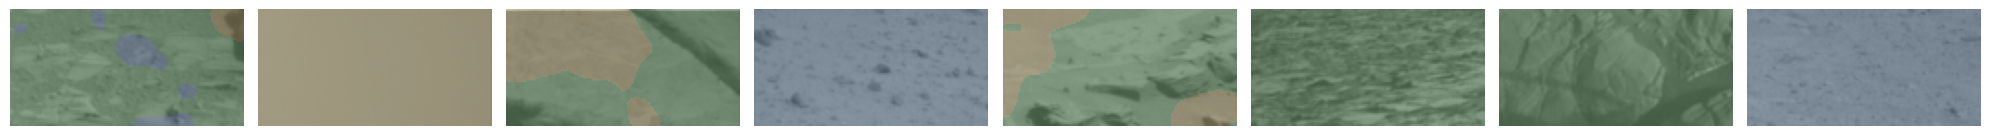

[4678, 5792, 4496, 3991, 7814, 4873, 5053, 7270]


In [24]:
num_img = 8
random_indices = random.sample(range(len(X_test)), num_img)


fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_test[idx,:,:,1]), cmap = 'nipy_spectral',vmin=0, vmax=4)
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

fig2, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(preds[idx]), cmap = 'nipy_spectral',vmin=0, vmax=4)
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

fig3, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(preds[idx]), cmap = 'nipy_spectral',vmin=0, vmax=4,alpha = 0.35)
    ax.imshow(np.squeeze(X_test[idx,:,:,0]), vmin=0, vmax=255,cmap='gray',alpha = 0.65)
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

print(random_indices)